**Mount Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Install required packages**

In [0]:
!pip install json_minify
!pip install imutils
!pip install pickle-mixin
!pip install mahotas

**Project Folder**

In [0]:
%cd "gdrive/My Drive/MAIA_AIA"

/content/gdrive/My Drive/MAIA_AIA


**Import the required libraries**

In [0]:
from matplotlib import pyplot as plt
import argparse
import cv2
import sys
from imutils import paths
import numpy as np
import imutils
from json_minify import json_minify
import json
from pyimagesearch.descriptors import LocalBinaryPatterns
from pyimagesearch.ir import BagOfVisualWords
import pickle
import random
import progressbar
from pyimagesearch.indexer import FeatureIndexer
import h5py
import mahotas

**load the configuration file that has the paths to images**

In [0]:
conf = json.loads(json_minify(open('mass.json').read()))


#Pre-processing

**reading an image**

(4084, 3328)

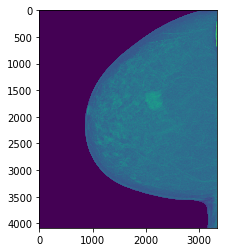

In [0]:
image = cv2.imread('dataset/positiveImages/22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.tif', cv2.IMREAD_UNCHANGED)
plt.imshow(image)
image.shape

**resize and apply CLAHE for enhancement**

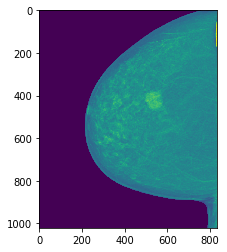

In [0]:
#resize and apply CLAHE
image = cv2.resize(image, (0,0), fx=0.25, fy=0.25)
clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(4,4))
image_clahe = clahe.apply(image)
#Converting to uint8
image_clahe = cv2.normalize(image_clahe, dst=None, alpha=0, beta=65536, norm_type=cv2.NORM_MINMAX)
image_clahe = (image_clahe / 255).astype('uint8')
(h, w) = image_clahe.shape[:2]
plt.imshow(image_clahe)

**apply Multi-scale Morphological Sifting**

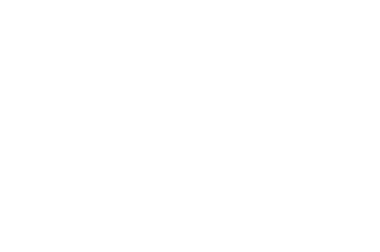

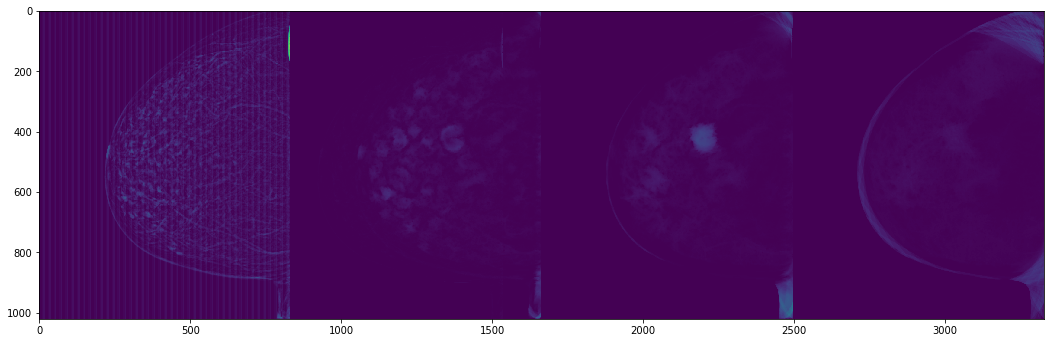

In [0]:
#apply Multi-scale Morphological Sifting
def Morphological_sifting(enhanced, len1, len2):
  kernel1 = np.zeros((len1,len1),np.uint8)
  kernel1=cv2.line(kernel1, (int(len1/2),1),(int(len1/2),len1-2), 1, thickness=2)    
  kernel2 = np.zeros((len2,len2),np.uint8)
  kernel2=cv2.line(kernel2, (int(len2/2),1),(int(len2/2),len2-2),1,  thickness=2)    


  openedStack = np.empty(shape=[h,w], dtype = np.uint8)

  #tophatStack = np.empty(shape=[h,w], dtype = np.uint16)
  N=18
  for i in range(0, N):
    #print (" i = ", i)
    #M1 = cv2.getRotationMatrix2D((len1/2, len1/2), 180*(i/N), 1.0)

    #rotate kernel1 by 180*i/N clock wise
    #rotated_Kernel1 = cv2.warpAffine(kernel1, M1, (len1, len1))
    rotated_Kernel1 = imutils.rotate(kernel1,  -(180*(i/N)))
    #apply tophat
    tophat = cv2.morphologyEx(enhanced, cv2.MORPH_TOPHAT, rotated_Kernel1)



    #M2 = cv2.getRotationMatrix2D((len2/2, len2/2), 180*(i/N), 1.0)
    #rotated_Kernel2 = cv2.warpAffine(kernel2, M2, (len2, len2))
    rotated_Kernel2 = imutils.rotate(kernel2,  -(180*(i/N)))
    opened = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, rotated_Kernel2)   
    #store it
    openedStack = np.dstack((openedStack, opened))
  sifted_img=np.sum(openedStack,axis=2,dtype = np.uint16)
  #print("sifted_img = ",sifted_img.shape)

  return sifted_img

def get_sifted_images(enhanced):
    
  sifted_img1 = Morphological_sifting(enhanced,32,4);
  sifted_img2 = Morphological_sifting(enhanced,64,32);
  sifted_img3 = Morphological_sifting(enhanced,128,64);
  sifted_img4 = Morphological_sifting(enhanced,256,128);


  return sifted_img1, sifted_img2, sifted_img3, sifted_img4      
    

sifted_img1, sifted_img2, sifted_img3, sifted_img4 = get_sifted_images(image_clahe)


plt.axis('off')
plt.figure(figsize=(18,6))
plt.imshow( np.concatenate([sifted_img1, sifted_img2, sifted_img3 ,sifted_img4], axis = 1))


#Apply Selective Search to extract candidates

**first we obtain initial candidates for each scale of the sifted images and then we apply some conditions to get a shortlisted candidates**

In [0]:
#add the 4 sifted images in one list
sifted_list = []
sifted_list.append(sifted_img1)
sifted_list.append(sifted_img2)
sifted_list.append(sifted_img3)
sifted_list.append(sifted_img4)

print(len(sifted_list))

print(sifted_list[0].shape)

4
(1021, 832)


mask size (4084, 3328)
new mask size (450, 366)
Total Number of initial Proposals: 543
Total Number of final proposals: 91
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
len(shortlistedRects) 91
mask size (4084, 3328)
new mask size (450, 366)
Total Number of initial Proposals: 580
Total Number of final proposals: 120
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
len(shortlistedRects) 120
mask size (4084, 3328)
new mask size (450, 366)
Total Number of initial Proposals: 271
Total Number of final proposals: 54
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
len(shortlistedRects) 54
mask size (4084, 3328)
new mask size (450, 366)
Total Number of initial Proposals: 395
Total Number of final proposals: 115
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
len(shortlistedRects) 115


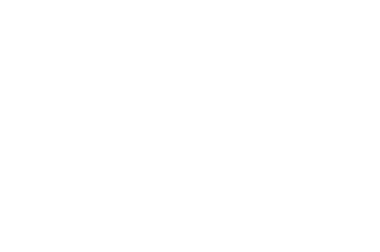

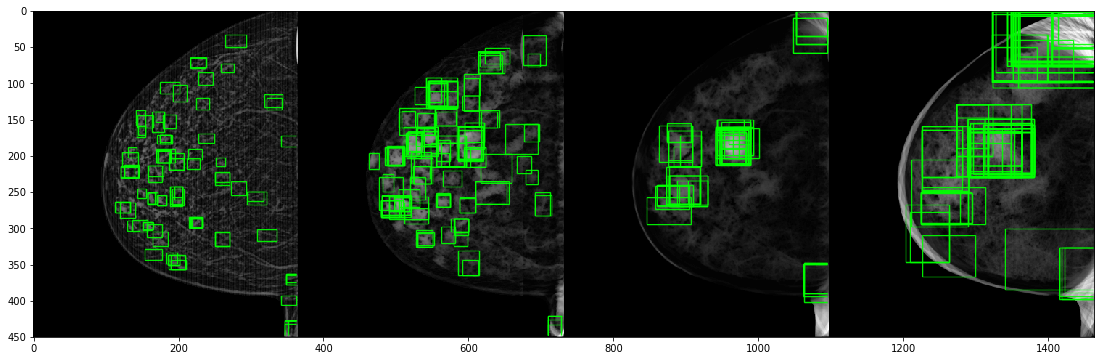

In [0]:
# initialize list of shortlistedRects
shortlistedRects_list = []
num_rects_per_image = 0
num_rects_per_image = 0
num_shortlistedRects = []

clone_list = []


for i in range(1, 5):
    
    # bb area limiting conditions based on structuring element size of each scale in sifted images
    if i == 1:
        minArea = 50
        maxArea = 500
        minSumVal = 16500
    elif i == 2:
        minArea = 300
        maxArea = 1900
        minSumVal = 24500
    elif i == 3:
        minArea = 700
        maxArea = 2500
        minSumVal = 67500
    else: # i == 4
        minArea = 2300
        maxArea = 15000
        minSumVal = 330000

    image = sifted_list[i-1]
    # resize sifted image
    image = imutils.resize(image, height=conf["ImageNewHeight"])
    # normalize and covert to uint8
    image = cv2.normalize(image, dst=None, alpha=0, beta=65536, norm_type=cv2.NORM_MINMAX)
    image = (image / 256).astype('uint8')

    # apply CLAHE to sifted images
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    image = clahe.apply(image)
    #transform to rgb
    image = np.stack((image,) * 3, axis=-1)
    # load the mask and resize it
    # extract mask ID
    maskID = '22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.mask.png'

    # load the mask and resize it
    maskpath = "dataset/masks/{}".format(maskID)
    mask = cv2.imread(maskpath, cv2.IMREAD_UNCHANGED)
    print("mask size",mask.shape)
    mask = imutils.resize(mask, height=conf["ImageNewHeight"])
    print("new mask size",mask.shape)

    # apply mask to the image
    image = cv2.bitwise_and(image, image, mask=mask)
    
    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(image)

    # Switch to high recall but slow Selective Search method if ssQuality flag is true
    ss.switchToSelectiveSearchQuality() if conf["use_ssQuality"] else ss.switchToSelectiveSearchFast()

    # run selective search segmentation on input image
    rects = ss.process()
    print('Total Number of initial Proposals: {}'.format(len(rects)))

    # initialize shortlistedRects
    shortlistedRects = []
    numRects = 0
    
    # loop through extracted proposals from selective search and take only the suitable ones
    for rect in rects:

        # calculate area and aspect ratio of the rects
        x, y, w, h = rect
        areaRect = w * h
        aspRatioRect = w / h

        # extrach sifted roi from the sifted image
        sifted_patch = image[y:y + h, x:x + w]

        # calculate the sum of pixels in the ROI
        sumVal = np.sum(sifted_patch)

        # crop the rect binary ROI with in the breast mask and calculate num of zero pixels
        rectRoi = mask[y:y + h, x:x + w]
        numZeros = areaRect - np.count_nonzero(rectRoi, axis=(0, 1))
        zerosRatio = numZeros / areaRect

        # check if rects' areas and aspect ratios within range and add rect to the shortlisted rects
        if areaRect > minArea and areaRect < maxArea:
            if aspRatioRect > conf["roiMinAspRatio"] and aspRatioRect < conf["roiMaxAspRatio"]:
                if zerosRatio < conf["zerosRatio"]:
                    if sumVal > minSumVal:
                        if numRects >= 120:
                            break
                        else:
                            # append rect to shortlisted rects and extract ROI patch
                            shortlistedRects.append(rect)
                            numRects = numRects + 1

    print('Total Number of final proposals: {}'.format(len(shortlistedRects)))
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    num_shortlistedRects.append(len(shortlistedRects))

    num_rects_per_image += len(shortlistedRects)
    
    shortlistedRects_list.append(shortlistedRects)
    


   # print('Total Number of final proposals: {}'.format(len(shortlistedRects)))
    #print(len(shortlistedRects_list))

    #show overlay bb after padding
    clone2 = image.copy()
    print("len(shortlistedRects)",len(shortlistedRects))
    for rect in shortlistedRects:
      #print("rect",rect)

      x, y, w, h = rect
      cv2.rectangle(clone2, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
      #plt.imshow(clone2)
    clone_list.append(clone2)

plt.axis('off')
plt.figure(figsize=(20,6))
plt.imshow( np.concatenate([clone_list[0], clone_list[1], clone_list[2] ,clone_list[3]], axis = 1))


#Feature extraction

we used bag of words with LBP and Haralick features

In [0]:
#extracting features for one of the obtained rects of the previously processed image

# initialize the local binary patterns descriptor
lbp = LocalBinaryPatterns(24, 8)
### initialize haralick features and LBP features lists
haralick_features = []
lbp_featuers = []
#obtain one of the bounding boxes
rects = shortlistedRects_list[0]
x, y, w, h = rects[5]
sifted_patch = image[y:y + h, x:x + w]
sifted_patch = cv2.cvtColor(sifted_patch, cv2.COLOR_BGR2GRAY)
# extrach haralick texture features LBP from sifted images
haralick = mahotas.features.haralick(sifted_patch).mean(axis=0)
hist = lbp.describe(sifted_patch)
haralick_features.append(haralick)
lbp_featuers.append(hist)

print ('Length of haralick features: {}'.format(haralick_features[0].shape))
print ('Length of LBP features: {}'.format(lbp_featuers[0].shape))

Length of haralick features: (13,)
Length of LBP features: (26,)


**For the bag of words we will just show the shape of the feature vector from saved file, as it needs all the dataset images for clustering to get the final feature vector, please refer to the full project notebook for details**

In [0]:
bovw_db = 'output/sumVal_all_bovw_100.hdf5'
bovwDB = h5py.File(bovw_db)
bovw = bovwDB["bovw"]

print (bovw.shape)



(28350, 100)


#Showing the prediction for a sample image

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator BaggingClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


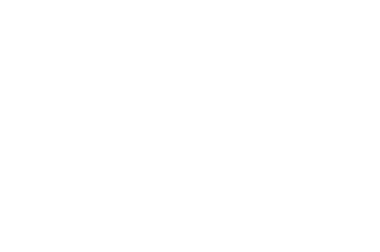

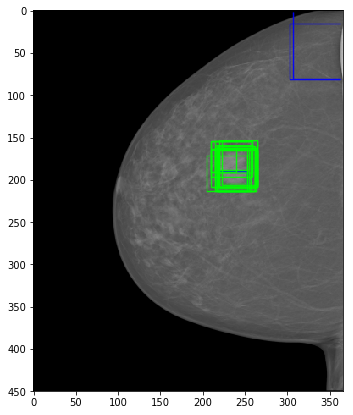

In [0]:
hard_negative = True
fold_num = 0

# get the file paths
features_db = 'output/sumVal_features.hdf5'
bovw_db = 'output/sumVal_all_bovw_100.hdf5'
modelPath = 'output/all_model_k' + str(fold_num) + '.cpickle'
imIdxsPath = 'output/sumVal_imageIdxs_rois.hdf5'
newFPath = 'output/sumVal_harLbp_features.hdf5'

if hard_negative:
    modelPath = 'output/hard_model_k' + str(fold_num) + '.cpickle'


# load the classifier
model = pickle.loads(open(modelPath, "rb").read())

# open the features and bag-of-visual-words databases
featuresDB = h5py.File(features_db)
bovwDB = h5py.File(bovw_db)
imIdxsDB = h5py.File(imIdxsPath)
newFDB = h5py.File(newFPath)



# get the image indecies
imIdxs = imIdxsDB['im_idxs']
labels = featuresDB['image_ids']
bovw = bovwDB["bovw"]
haralick = newFDB["haralick_features"]
lbp = newFDB["lbp_features"]

# features = lbp
features = np.concatenate((haralick, lbp, bovw), axis=1)


test_image_idxs = imIdxs[7] #the idx of the image showed previously

patchesFeatures = features[test_image_idxs[0]:test_image_idxs[1]]
patchesROIs = imIdxsDB['rois'][test_image_idxs[0]:test_image_idxs[1]]
patchesLabels = featuresDB['image_ids'][test_image_idxs[0]:test_image_idxs[1]]

imageID = patchesLabels[0].split("@")[0] + '.tif'
#
image2 = cv2.imread('dataset/images/{}'.format(imageID))
image2 = imutils.resize(image2, height=conf["ImageNewHeight"])


# initialize matching list and mass detected flag
#massMatchList = np.zeros((len(gtROIs), 1), dtype=int)



clone = image2.copy()
# initialize TP,TN, FP, FN
TP = 0
TN = 0
FP = 0
FN = 0

# initialize TP rois and matching lists
tp_rois = []
tp_area = []
massList1 = None
massList2 = None

prob_thresh = 0.5
for (q, coord) in enumerate(patchesROIs):

    # extract bounding box
    x, y, w, h = coord
    label = featuresDB["image_ids"][test_image_idxs[0]:test_image_idxs[1]][q].split("@")[1]
    roi_features = features[test_image_idxs[0]:test_image_idxs[1]][q]
    f = []
    f.append(roi_features)
    prediction = model.predict(f)

    # get the probability of being a mass
    prob = model.predict_proba(f)[0][0]

    if prob > prob_thresh:
        pred_label = "Mass"
    else:
        pred_label = "Not_Mass"
    # print(roi_idx)
    # roi_features = db2['features'][roi_idx[0]:roi_idx[1]]
    # k = 0
    if pred_label == "Mass" and label == "Mass":
        cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
        tp_rois.append(coord)
    elif pred_label == "Mass" and label == "Not_Mass":
        cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 0, 255), 1, cv2.LINE_AA)
        FP += 1
    elif pred_label == "Not_Mass" and label == "Not_Mass":
        #print("proposal: {}/{}".format(q, len(patchesLabels)))
        TN += 1
plt.axis('off')
plt.figure(figsize=(12,7))        
plt.imshow(clone)

#Final segmentation of the mass for the above sample image

In [0]:
def get_biggets_component (th3):
    '''
    obtain the largest connected component from the thresholded roi
    '''
    image = th3.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 1
    #plt.imshow("Biggest component", img2)
    return img2


def get_mass_mask(image,roi, x, y, w, h):
    '''
    This function receives the original, roi, 
    x, y, w, h of roi in original image, segments the mass 
    from roi and places it onto the place in roi coordinates
    '''
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(roi,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    fin=get_biggets_component (th3)
    fin_output=np.zeros(image.shape,dtype=np.uint8)
    fin_output[y:y + h, x:x + w]=fin
    return fin_output

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator BaggingClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


size (450, 366, 3) type uint8


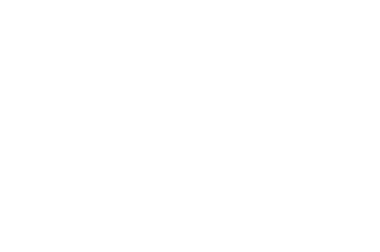

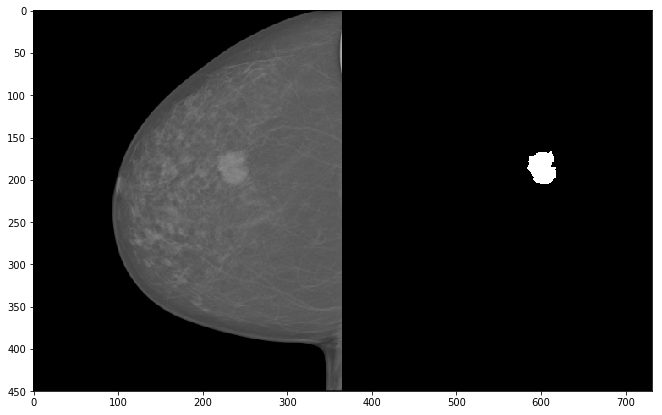

In [0]:
hard_negative = True
fold_num = 0

# get the file paths
features_db = 'output/sumVal_features.hdf5'
bovw_db = 'output/sumVal_all_bovw_100.hdf5'
modelPath = 'output/all_model_k' + str(fold_num) + '.cpickle'
imIdxsPath = 'output/sumVal_imageIdxs_rois.hdf5'
newFPath = 'output/sumVal_harLbp_features.hdf5'

if hard_negative:
    modelPath = 'output/hard_model_k' + str(fold_num) + '.cpickle'


# load the classifier
model = pickle.loads(open(modelPath, "rb").read())

# open the features and bag-of-visual-words databases
featuresDB = h5py.File(features_db)
bovwDB = h5py.File(bovw_db)
imIdxsDB = h5py.File(imIdxsPath)
newFDB = h5py.File(newFPath)



# get the image indecies
imIdxs = imIdxsDB['im_idxs']
labels = featuresDB['image_ids']
bovw = bovwDB["bovw"]
haralick = newFDB["haralick_features"]
lbp = newFDB["lbp_features"]

# features = lbp
features = np.concatenate((haralick, lbp, bovw), axis=1)


test_image_idxs = imIdxs[7] #the idx of the image showed previously

patchesFeatures = features[test_image_idxs[0]:test_image_idxs[1]]
patchesROIs = imIdxsDB['rois'][test_image_idxs[0]:test_image_idxs[1]]
patchesLabels = featuresDB['image_ids'][test_image_idxs[0]:test_image_idxs[1]]

imageID = patchesLabels[0].split("@")[0] + '.tif'
#
image2 = cv2.imread('dataset/images/{}'.format(imageID))

image2 = imutils.resize(image2, height=conf["ImageNewHeight"])

clone = image2.copy()
orig_image = image2.copy()
print("size",orig_image.shape,"type",orig_image.dtype)
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2GRAY)
prob_thresh = 0.5
for (q, coord) in enumerate(patchesROIs):

   fin_output=np.zeros(orig_image.shape,dtype=np.uint8)
for (q, coord) in enumerate(patchesROIs):
   # extract bounding box
    x, y, w, h = coord
    #label = featuresDB["image_ids"][test_image_idxs[0]:test_image_idxs[1]][q].split("@")[1]
    roi_features = features[test_image_idxs[0]:test_image_idxs[1]][q]
    f = []
    f.append(roi_features)
    prediction = model.predict(f)

    # get the probability of being a mass
    prob = model.predict_proba(f)[0][0]

    if prob > prob_thresh:
        pred_label = "Mass"
    else:
        pred_label = "Not_Mass"
    # print(roi_idx)
    # roi_features = db2['features'][roi_idx[0]:roi_idx[1]]
    # k = 0
    
    
    if pred_label == "Mass":
     
      #Converting to uint8
      clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(8,8))
      image_clahe = clahe.apply(orig_image)
      

      im_clone= image_clahe
      roi = im_clone[y:y + h, x:x + w]
      mass=get_mass_mask(image_clahe,roi, x, y, w, h)
      fin_output=fin_output+mass
ret3,th3 = cv2.threshold(fin_output,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
out = np.stack((th3,) * 3, axis=-1)

plt.axis('off')
plt.figure(figsize=(18,7))
plt.imshow( np.concatenate([np.stack((orig_image,) * 3, axis=-1),out], axis = 1))


#Testing the model and plotting the FROC

**plotting the FROC by reading the previously saved TPR & FPPI (for 10 points)**

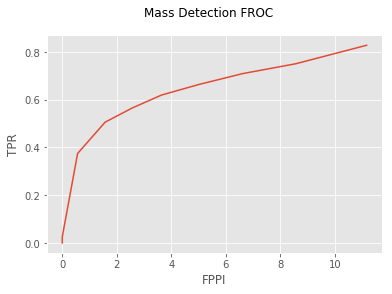

In [0]:
frocPointsPath = 'output/froc_points.cpickle'
frocPoints = pickle.loads(open(frocPointsPath, "rb").read())
x = frocPoints[:, 2]
y = frocPoints[:, 1]

# plot the froc curve
fig = plt.figure()
plt.style.use("ggplot")
plt.suptitle('Mass Detection FROC')
plt.xlabel('FPPI')
plt.ylabel('TPR')

plt.plot(x, y)